# Custom Datasets

### Importing Images

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## Exploratory Data Analysis

### Directory Structure

In [2]:
from pathlib import Path

def walk_directory(directory:str | Path):
    # Create a Path object for the specified directory
    directory_path = Path(directory)
    n_file = 0
    # Iterate over the contents of the directory
    for entry in directory_path.iterdir():
        # Check if the entry is a directory
        if entry.is_dir():
            # You can recursively call the walk_directory function to explore subdirectories
            walk_directory(entry)
        else:
            n_file += 1 
    if n_file != 0:
        print(f"The {directory_path} directory has {n_file} files")

In [3]:
walk_directory("data")

The data/FashionMNIST/raw directory has 8 files
The data/pizza_steak_sushi/train/pizza directory has 78 files
The data/pizza_steak_sushi/train/steak directory has 75 files
The data/pizza_steak_sushi/train/sushi directory has 72 files
The data/pizza_steak_sushi/test/pizza directory has 25 files
The data/pizza_steak_sushi/test/steak directory has 19 files
The data/pizza_steak_sushi/test/sushi directory has 31 files
The data directory has 3 files


In [4]:
# Setup train and testing paths
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Creating a Custom Dataset

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import os
from  pathlib import Path
from torchvision.io import read_image

#### Transforms

In [6]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

data_transform_2 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor()
])

In [7]:
data_transform_experimental = transforms.Compose([
    transforms.Lambda(
        lambda 
            image: (
                [transforms.Resize(size=(64, 64))(image)] 
                + 
                [transforms.Resize(size=(64, 64))( 
                    transforms.RandomPerspective(distortion_scale=0.6, p=1.0)(image)
                ) for _ in range(4)]
                +
                [transforms.Resize(size=(64, 64))(
                    transforms.RandomRotation(degrees=(0, 180))(image)
                ) for _ in range(4)]
            )     
    ),
    # Turn the image into a torch.Tensor
    # this also converts all pixel values from [0, 255] to [0.0, 1.0] 
    transforms.Lambda(
        lambda 
            lista:torch.stack([transforms.ToTensor()(image) for image in lista])
    )
])

In [8]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_transformed_images(image_path: str | Path, transform, 
                            file_extension:str = "jpg", n=3, seed=42):
    """Plots a series of random images from image_path.

    Args:
        image_path: path, where image files are located. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    directory_path = Path(image_path)
    possible_images = [
        entry for entry in directory_path.iterdir() 
        if entry.is_file() and file_extension in str(entry)
    ]
    if possible_images !=[]:
        random_image_paths = random.sample(possible_images, k=n)
        for image in random_image_paths:
            with Image.open(image) as f:
                # Transform and plot image
                # Note: permute() will change shape of image to suit matplotlib 
                # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
                transformed_images = [trans_image.permute(1, 2, 0) 
                                      for trans_image in  transform(f)]
                fig, ax = plt.subplots(1, len(transformed_images)+1, figsize=(20, 2))
                ax[0].imshow(f) 
                ax[0].set_title(f"Original \nSize: {f.size}")
                ax[0].axis("off")
                # trans_image = transform(f).permute(1, 2, 0)
                for i,trans_image in enumerate(transformed_images, start=1):
                    ax[i].imshow(trans_image) 
                    ax[i].axis("off")
                    ax[i].set_title(f"Transformed Size:\n {trans_image.shape}")
                fig.suptitle(f"Class: {image.parent.stem}", fontsize=16)
                # Adjust layout to prevent clipping of titles
                plt.tight_layout()

                # Show the plots
                plt.show()
    else:
        raise Exception(
            f"The directory {image_path} has no images with extension {file_extension}"
        )

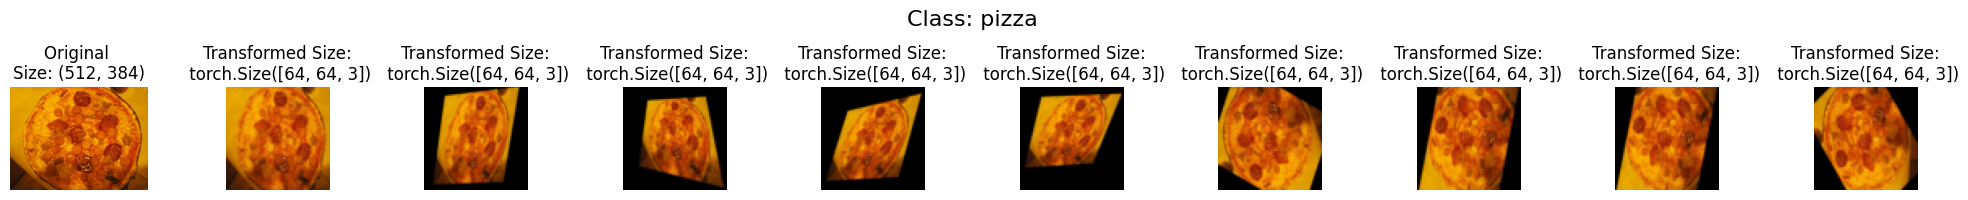

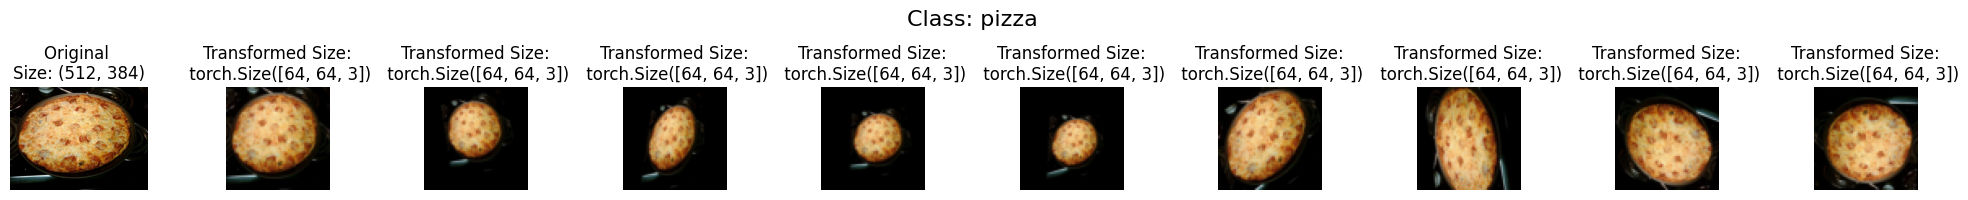

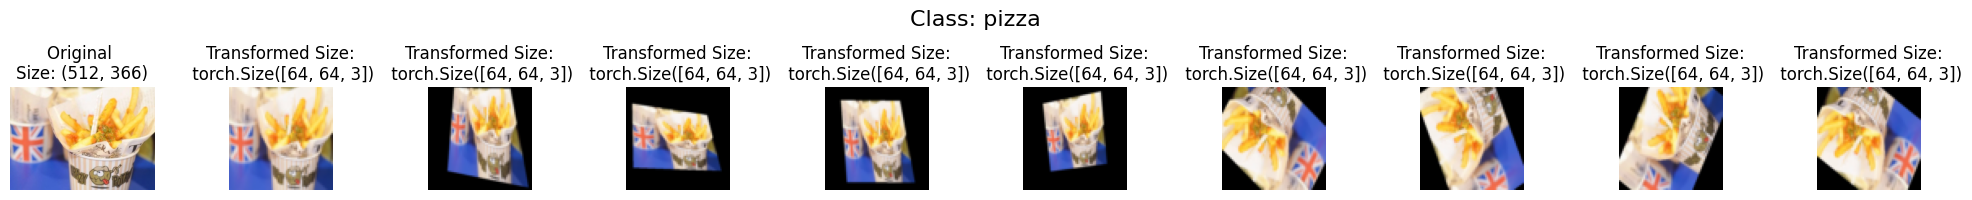

In [9]:
plot_transformed_images(image_path/"train"/"pizza", 
                        transform=data_transform_experimental, 
                        n=3)

In [10]:
image_path

PosixPath('data/pizza_steak_sushi')

#### Custom Class

A custom Dataset class must implement three dunder methods: `__init__`, `__len__`, and `__getitem__`.

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str, transform = None, target_transform = None):
        # in case annotations are in a csv file, uncomment below.
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.paths = list(self.img_dir.glob("*/*.jpg"))
        self._classes = sorted(
            entry.name for entry in os.scandir(self.img_dir) if entry.is_dir()
        )
        self._class_to_idx = {cls_name: i for i, cls_name in enumerate(self._classes)}
        self._idx_to_class = {i: cls_name for i, cls_name in enumerate(self._classes)}

    @property
    def classes(self):
        return self._classes
    @property
    def class_to_idx(self):
        return self._class_to_idx
    @property
    def idx_to_class(self):
        return self._idx_to_class
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int) -> tuple[Image.Image|torch.Tensor, int|torch.Tensor]:
        image = Image.open(str(self.paths[idx]))
        label = self._class_to_idx[self.paths[idx].parent.name]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"
train_data_custom = CustomImageDataset(img_dir = train_dir, 
                                      transform = data_transform)
test_data_custom = CustomImageDataset(img_dir = test_dir, 
                                     transform = data_transform)
train_data_custom, test_data_custom


(<__main__.CustomImageDataset at 0x7f23016a4af0>,
 <__main__.CustomImageDataset at 0x7f23016a55a0>)

In [13]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [14]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [15]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
train_data_custom.idx_to_class

{0: 'pizza', 1: 'steak', 2: 'sushi'}

In [17]:
train_data_custom[223][1]

2

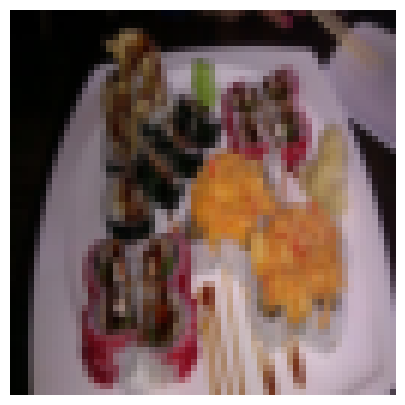

In [18]:
plt.figure(figsize=(10, 5))
plt.imshow(train_data_custom[223][0].permute(1, 2, 0))
plt.axis("off");


It looks like sushi! :)

### DataLoaders

In [19]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f23016505b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2301650b50>)

In [20]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### Model Building

In [21]:
from sklearn.metrics import classification_report
from torchmetrics import F1Score
from tqdm.auto import tqdm
from torch import nn
from typing import Any

/home/ivo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Make device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

#### Base Model

In [23]:
class BaseClass(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.train_loss_values = []
        self.test_loss_values = []
        self.f1_macro_train = []
        self.f1_macro_test = []
        self.f1_micro_train = []
        self.f1_micro_test = []
        self.f1_macro = F1Score(task="multiclass", num_classes = num_classes,
                          average="macro")
        self.f1_micro = F1Score(task="multiclass", num_classes = num_classes,
                          average="micro")

    def train_loop(self, dataloader: DataLoader, loss_fn:nn.modules.loss._Loss, 
                   optimizer: torch.optim.Optimizer) -> tuple[Any,Any,Any]:
        size = len(dataloader.dataset) # type: ignore
        num_batches = len(dataloader)
        self.train()
        train_loss,f1_macro, f1_micro = 0,0,0
        for batch, (input, labels) in enumerate(dataloader):
            input, labels = input.to(device), labels.to(device)
            # CrossEntropyLoss works directly with logits as inputs
            logits = self(input)
            # CrossEntropyLoss expects a tensor of type long as targets.
            # if we don't do the type casting outside the loss function, we get an error
            labels_long = labels.to(dtype=torch.long)
            loss = loss_fn(logits, labels_long)
            # we'll add the loss accross batches/steps, and in the end average them.
            # and for this, we need a new variable like train_loss to avoid  
            # RuntimeError:Trying to backward through the graph a second time
            train_loss += loss
            # return rows with prob like quantities of size 6
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1) 
            f1_macro += self.f1_macro(pred, labels)
            f1_micro += self.f1_micro(pred, labels)  
            # also equal to self.f1(nn.Softmax(dim=1)(logits), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # uncomment below for printing losses during batch training
            # if batch % 100 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss /= num_batches
        f1_macro /= num_batches # I'm not sure about the implications of avg over f1 score...
        f1_micro /= num_batches
        return train_loss, f1_macro, f1_micro
    
    def test_loop(self, dataloader:DataLoader, 
                  loss_fn:nn.modules.loss._Loss) -> tuple[Any,Any,Any]:
        num_batches = len(dataloader)
        self.eval()
        with torch.inference_mode():
            test_loss,f1_macro, f1_micro = 0,0,0
            for batch, (input, labels) in enumerate(dataloader):
                input, labels = input.to(device), labels.to(device)
                logits = self(input)
                labels_long = labels.to(dtype=torch.long)
                loss = loss_fn(logits, labels_long)
                test_loss += loss
                pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
                f1_macro += self.f1_macro(pred, labels)
                f1_micro += self.f1_micro(pred, labels)
            test_loss /= num_batches
            f1_macro /= num_batches
            f1_micro /= num_batches 
        return test_loss, f1_macro, f1_micro
    
    def train_model(self, dataloader:DataLoader, loss_fn:nn.modules.loss._Loss, 
                    optimizer: torch.optim.Optimizer, n_epochs:int = 100, 
                    verbose: bool = False) -> None:
        for epoch in tqdm(range(1,n_epochs+1)):
            train_loss, train_f1_macro, train_f1_micro = self.train_loop(
                dataloader = dataloader, loss_fn = loss_fn, optimizer = optimizer
            )
            self.train_loss_values.append(train_loss.detach().cpu().numpy())
            self.f1_macro_train.append(train_f1_macro.detach().cpu().numpy())
            self.f1_micro_train.append(train_f1_micro.detach().cpu().numpy())
            test_loss, test_f1_macro, test_f1_micro = self.test_loop(
                dataloader = dataloader, loss_fn = loss_fn
            )
            self.test_loss_values.append(test_loss.detach().cpu().numpy())
            self.f1_macro_test.append(train_f1_macro.detach().cpu().numpy())
            self.f1_micro_test.append(train_f1_micro.detach().cpu().numpy())
            if verbose:
                print(f"\nEpoch {epoch}\n-------------------------------")
                print(
                    f"{loss_fn._get_name()} Train Loss: {train_loss} |"
                    f"{loss_fn._get_name()} Test Loss: {test_loss}"
                )
                print(
                    f"F1 Train Score (macro,micro): {train_f1_macro,train_f1_micro}  |"
                    f"F1 Test Score (macro,micro): {test_f1_macro,test_f1_micro}"
                )
    
    def predict(self, input: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.inference_mode():
            logits = self(input.to(device=device, dtype=torch.float32))
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
        return pred
    
    def evaluation_report(self, dataloader: DataLoader, labels_names: list[str]):
        y_pred = []
        y_true = []
        for batch, (inputs_per_batch, labels_per_batch) in enumerate(dataloader):
                y_pred.append(self.predict(inputs_per_batch).cpu().numpy())
                y_true.append(labels_per_batch.cpu().numpy())
        print(classification_report(y_pred = y_pred, y_true = y_true,
                                target_names = labels_names))
        
    def plot_loss_curves(self): 
        epochs = range(len(self.test_loss_values))
        # Setup a plot 
        plt.figure(figsize=(15, 7))
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_loss_values, label='Train')
        plt.plot(epochs, self.test_loss_values, label='Test')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot f1 Macro
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.f1_macro_train, label='Train')
        plt.plot(epochs, self.f1_macro_test, label='Test')
        plt.title('F1 Macro')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot f1 Micro
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.f1_micro_train, label='Train')
        plt.plot(epochs, self.f1_micro_test, label='Test')
        plt.title('F1 Micro')
        plt.xlabel('Epochs')
        plt.legend();

#### Convolutional Model

In [24]:
class TinyVGG(BaseClass):
    """
    Model architecture copying TinyVGG from: 
    https://www.learnpytorch.io/03_pytorch_computer_vision/
    """
    def __init__(self, input_shape: int, 
                 hidden_units: int, output_shape: int, device: str = "cpu"):
        super().__init__(num_classes = output_shape)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, 
                      stride=1, padding=1, device = device), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      device=device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1, device=device),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1, device=device),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, 
                      out_features=output_shape, device=device)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

## Training The Model

In [25]:
import torchinfo
from torchinfo import summary

In [26]:
input_shape = 3 # number of channels. In our case we just have 1, greyscale.
hidden_units = 20
output_shape = 3
learning_rate = 1e-3
n_epochs = 50

In [27]:
conv_model = TinyVGG(input_shape = input_shape,hidden_units = hidden_units,
                        output_shape = output_shape)
conv_model = conv_model.to(device = device)

conv_loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
conv_optimizer = torch.optim.SGD(params = conv_model.parameters(), lr = learning_rate)

In [28]:
# summary(conv_model, input_size=[1, 3, 64, 64])
# be carefull with above, it will move stuff to GPU, while I want to work below in CPU... 

In [29]:
conv_model.train_model(train_dataloader_custom, loss_fn= conv_loss_fn, 
                      optimizer= conv_optimizer, n_epochs = n_epochs)

100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


In [30]:
conv_model.evaluation_report(test_dataloader_custom,
                            labels_names = test_data_custom.classes
                            )

              precision    recall  f1-score   support

       pizza       0.44      0.72      0.55        25
       steak       0.56      0.47      0.51        19
       sushi       0.61      0.35      0.45        31

    accuracy                           0.51        75
   macro avg       0.54      0.52      0.50        75
weighted avg       0.54      0.51      0.50        75



Notice that the test dataset also suffered the transformations...
In a real setting, only the train dataset would be transformed/augmented.
The test set, should be as is!


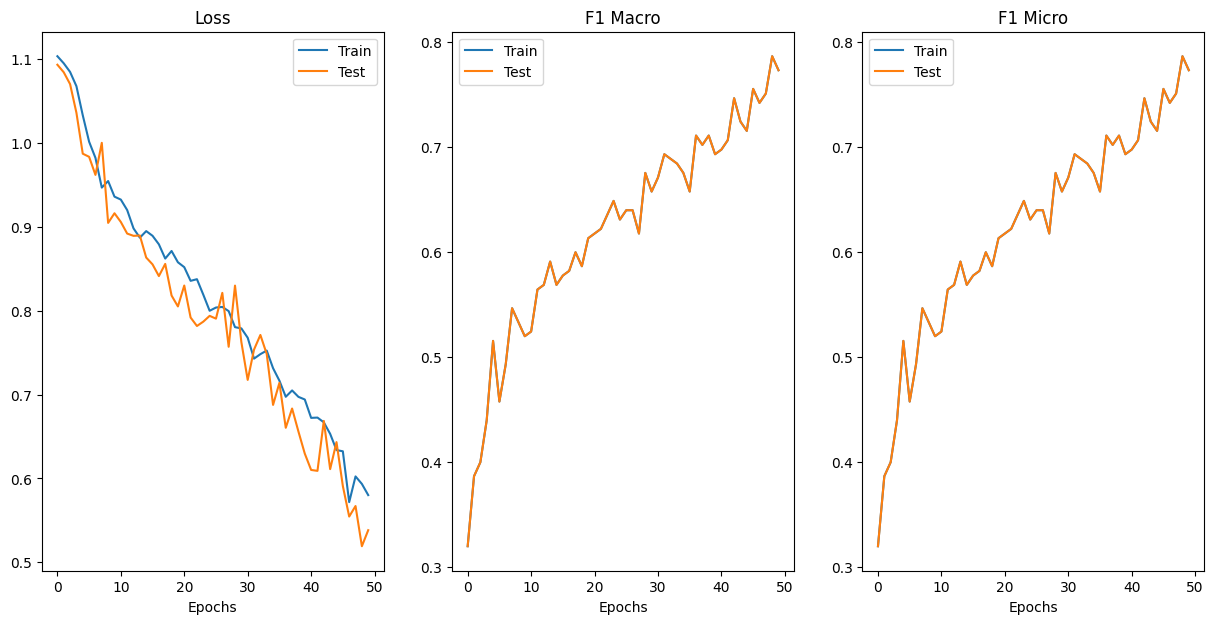

In [31]:
conv_model.plot_loss_curves()

Clearly, since the loss hasn't stabilized, we could increase the number of epochs, or simply rerun the train_model method (it will start at the last time, it seems...)

Something strange is that the F1 metrics are the same for the train and test set, hence only seeing the last line (test) on the graphs... I should check this later.

Also, we would expect the train loss to be lower than the test loss... This could be accidental. Also, as we run through the epochs, the relationship increasingly gets reversed.

### With Untransformed Test Dataset

Except resizing and to tensor...

In [32]:
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
test_data_untransformed = CustomImageDataset(img_dir = test_dir, transform = simple_transform)
test_dataloader_untransformed = DataLoader(dataset=test_data_untransformed, batch_size=1, 
                                           num_workers=0, shuffle=False)
conv_model.evaluation_report(test_dataloader_untransformed,
                            labels_names = test_data_untransformed.classes
                            )

              precision    recall  f1-score   support

       pizza       0.42      0.68      0.52        25
       steak       0.56      0.47      0.51        19
       sushi       0.58      0.35      0.44        31

    accuracy                           0.49        75
   macro avg       0.52      0.50      0.49        75
weighted avg       0.52      0.49      0.49        75



### With Experimental Custom Dataset

In [33]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"
train_data_experimental = CustomImageDataset(img_dir = train_dir, 
                                      transform = data_transform_experimental)
test_data_experimental = CustomImageDataset(img_dir = test_dir, 
                                     transform = data_transform_experimental)
train_dataloader_experimental = DataLoader(dataset=train_data_experimental, batch_size=1, num_workers=0, 
                                     shuffle=True)
test_dataloader_experimental = DataLoader(dataset=test_data_experimental, batch_size=1, num_workers=0, 
                                    shuffle=False)
conv_model_2 = TinyVGG(input_shape = input_shape,hidden_units = hidden_units,
                        output_shape = output_shape).to("cpu")

conv_loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
conv_optimizer_2 = torch.optim.SGD(params = conv_model_2.parameters(), lr = learning_rate)
conv_model_2.train_model(train_dataloader_experimental, loss_fn= conv_loss_fn, 
                      optimizer= conv_optimizer_2, n_epochs = n_epochs) 

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 9, 3, 64, 64]

In [ ]:
conv_model_2.evaluation_report(test_dataloader_untransformed,
                            labels_names = test_data_untransformed.classes
                            )